In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import plotly as pt

In [2]:
#demand function, el is elasticity of demand
def demand(price,level,el):
    return level*price**el

#supply function, el is elastacity

def supply(price,level,el):
    return level*price**el

#inverse demand to be able to find the price easier

def inverse_demand(x,level,el):
    return (x/level)**(1/el)

#excess supply function

def excess_supply(price,d_level,d_el,s_level,s_el):
    return supply(price,s_level,s_el)-demand(price,d_level,d_el)

#solver to find the price levels given the functions above

res=opt.root(excess_supply,np.array([1]),args=(10.0,-2.0,9.0,0.0))
print(res.x)

[1.05409255]


In [3]:
# need to be able to add a term in the excess supply function because we will need it to find price

def excess_supply(price,d_level,d_el,s_level,s_el, addterm):
    return supply(price,s_level,s_el)-demand(price,d_level,d_el)+addterm

# We only need one of these functions. We need to be able to add/subtract a term.

# define the excess supply for island 1 and 2
def common_excess_supply_two(price, d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, addterm):
    # calculate supply and demand for the first island
    excess_island1 = supply(price, s_level1, s_el1) - demand(price, d_level1, d_el1)
    # calculate supply and demand for the second island
    excess_island2 = supply(price, s_level2, s_el2) - demand(price, d_level2, d_el2)
    # sum up the excess supply from all three islands
    total_excess = excess_island1 + excess_island2 + addterm
    return total_excess

#define the excess supply for island 1 and 2 and 3

def common_excess_supply_three_island(price, d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, d_level3, d_el3, s_level3, s_el3):
    # calculate supply and demand for the first island
    excess_island1 = supply(price, s_level1, s_el1) - demand(price, d_level1, d_el1)
    # calculate supply and demand for the second island
    excess_island2 = supply(price, s_level2, s_el2) - demand(price, d_level2, d_el2)
    # calculate supply and demand for the third island
    excess_island3 = supply(price, s_level3, s_el3) - demand(price, d_level3, d_el3)
    # sum up the excess supply from all three islands
    total_excess = excess_island1 + excess_island2 + excess_island3
    return total_excess

In [4]:


def three_islands(d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, d_level3, d_el3, s_level3, s_el3, cap12, cap13, cap23):
    whichcase = np.zeros(13)
    prices1 = np.zeros(13)
    prices2 = np.zeros(13)
    prices3 = np.zeros(13)

    # Scenario 0: 1 unified market
    prices1[0] = prices2[0] = prices3[0] = opt.bisect(
        common_excess_supply_three_island, 1e-8, 10,
        args=(d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, d_level3, d_el3, s_level3, s_el3))

    # Calculate excess supply for each island at the initial price
    ES1 = excess_supply(prices1[0], d_level1, d_el1, s_level1, s_el1, 0)
    ES2 = excess_supply(prices2[0], d_level2, d_el2, s_level2, s_el2, 0)
    ES3 = excess_supply(prices3[0], d_level3, d_el3, s_level3, s_el3, 0)

    # Check if initial excess supplies are within transmission capacities
    if abs(ES1) < cap12 + cap13 and abs(ES2) < cap12 + cap23 and abs(ES3) < cap13 + cap23:
        whichcase[0] = 1
        return whichcase, prices1, prices2, prices3
    else:
        # Scenario 1: 2 markets, p1 > p23
        prices1[1] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, +cap12 + cap13))
        prices2[1] = prices3[1] = opt.bisect(
            common_excess_supply_two, 1e-8, 10,
            args=(d_level2, d_el2, s_level2, s_el2, d_level3, d_el3, s_level3, s_el3, -cap12 - cap13))

        ES2 = excess_supply(prices2[1], d_level2, d_el2, s_level2, s_el2, +cap12)
        ES3 = excess_supply(prices3[1], d_level3, d_el3, s_level3, s_el3, +cap13)

        if abs(ES2) < cap23 and prices1[1] > prices2[1]:
            whichcase[1] = 1
            return whichcase, prices1, prices2, prices3
        # Scenario 2: 2 markets, p1 < p23
        prices1[2] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, -cap12 - cap13))
        prices2[2] = prices3[2] = opt.bisect(
            common_excess_supply_two, 1e-8, 10,
            args=(d_level2, d_el2, s_level2, s_el2, d_level3, d_el3, s_level3, s_el3, +cap12 + cap13))

        ES2 = excess_supply(prices2[2], d_level2, d_el2, s_level2, s_el2, -cap12)
        ES3 = excess_supply(prices3[2], d_level3, d_el3, s_level3, s_el3, -cap13)

        if abs(ES2) < cap23 and prices1[2] < prices2[2]:
            whichcase[2] = 1
            return whichcase, prices1, prices2, prices3
        # Scenario 3: 2 markets, p2 >  p13
        prices2[3] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, +cap12 + cap23))
        prices1[3] = prices3[3] = opt.bisect(
            common_excess_supply_two, 1e-8, 10,
            args=(d_level1, d_el1, s_level1, s_el1, d_level3, d_el3, s_level3, s_el3, -cap12 - cap23))

        ES1 = excess_supply(prices1[3], d_level1, d_el1, s_level1, s_el1, cap12)
        ES3 = excess_supply(prices3[3], d_level3, d_el3, s_level3, s_el3, cap23)

        if abs(ES1) < cap13 and prices2[3] > prices1[3]:
            whichcase[3] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario 4: 2 markets, p2 > p13
        prices2[4] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, -cap12 - cap23))
        prices1[4] = prices3[4] = opt.bisect(
            common_excess_supply_two, 1e-8, 10,
            args=(d_level1, d_el1, s_level1, s_el1, d_level3, d_el3, s_level3, s_el3, +cap12 + cap23))

        ES1 = excess_supply(prices1[4], d_level1, d_el1, s_level1, s_el1, -cap12)
        ES3 = excess_supply(prices3[4], d_level3, d_el3, s_level3, s_el3, -cap23)

        if abs(ES1) < cap13 and prices2[4] < prices1[4]:
            whichcase[4] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario 5: 2 markets, p3 > p12
        prices3[5] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, +cap13 + cap23))
        prices1[5] = prices2[5] = opt.bisect(
            common_excess_supply_two, 1e-8, 10,
            args=(d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, -cap13 - cap23))

        ES1 = excess_supply(prices1[5], d_level1, d_el1, s_level1, s_el1, cap13)
        ES2 = excess_supply(prices2[5], d_level2, d_el2, s_level2, s_el2, cap23)

        if abs(ES1) < cap13 and prices3[5] > prices1[5]:
            whichcase[5] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario 6: 2 markets, p3 < p12
        prices3[6] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, -cap13 - cap23))
        prices1[6] = prices2[6] = opt.bisect(
            common_excess_supply_two, 1e-8, 10,
            args=(d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, cap13 + cap23))

        ES1 = excess_supply(prices1[6], d_level1, d_el1, s_level1, s_el1, -cap13)
        ES2 = excess_supply(prices2[6], d_level2, d_el2, s_level2, s_el2, -cap23)

        if abs(ES1) < cap13 and prices3[6] < prices1[6]:
            whichcase[6] = 1
            return whichcase, prices1, prices2, prices3


        # Scenario number 7: 3 markets, p1 > p2 > p3
        prices1[7] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, cap12 + cap13))
        prices2[7] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, -cap12 + cap13))
        prices3[7] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, -cap13 -cap12))

        ES2 = excess_supply(prices2[7], d_level2, d_el2, s_level2, s_el2, 0)
        ES3 = excess_supply(prices3[7], d_level3, d_el3, s_level3, s_el3, 0)

        if prices3[7] < prices2[7] and prices2[7] < prices3[7]:
            whichcase[7] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario number 8: 3 markets, p1 > p3 > p2
        prices1[8] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, cap12 + cap13))
        prices2[8] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, -cap12 - cap23))
        prices3[8] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, cap23 - cap13))

        ES2 = excess_supply(prices2[8], d_level2, d_el2, s_level2, s_el2, 0)
        ES3 = excess_supply(prices3[8], d_level3, d_el3, s_level3, s_el3, 0)

        if prices2[8] < prices3[8] and prices3[8] < prices1[8]:
            whichcase[8] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario number 9: 3 markets, p2 > p1 > p3
        prices1[9] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, (-cap12 + cap13)))
        prices2[9] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, cap23 + cap12))
        prices3[9] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, -cap13 - cap23))

        ES2 = excess_supply(prices2[9], d_level2, d_el2, s_level2, s_el2, 0)
        ES3 = excess_supply(prices3[9], d_level3, d_el3, s_level3, s_el3, 0)

        if prices3[9] < prices1[9] and prices1[9] < prices2[9]:
            whichcase[9] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario number 10: 3 markets, p2 > p3 > p1
        prices1[10] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, -cap12 -cap13))
        prices2[10] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, cap12 + cap23))
        prices3[10] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, cap13 - cap23))

        ES2 = excess_supply(prices2[10], d_level2, d_el2, s_level2, s_el2, 0)
        ES3 = excess_supply(prices3[10], d_level3, d_el3, s_level3, s_el3, 0)

        if prices1[10] < prices3[10] and prices3[10] < prices2[10]:
            whichcase[10] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario number 11: 3 markets p3>p2>p1
        prices1[11] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, -cap12 - cap13))
        prices2[11] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, cap12 - cap23))
        prices3[11] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, cap23 + cap13))

        ES2 = excess_supply(prices2[11], d_level2, d_el2, s_level2, s_el2, 0)
        ES3 = excess_supply(prices3[11], d_level3, d_el3, s_level3, s_el3, 0)

        if prices1[11] < prices2[11] and prices2[11] < prices3[11]:
            whichcase[11] = 1
            return whichcase, prices1, prices2, prices3

        # Scenario number 12: 3 markets, p3>p1>p2
        prices1[12] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level1, d_el1, s_level1, s_el1, cap13 - cap12))
        prices2[12] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level2, d_el2, s_level2, s_el2, cap23 + cap12))
        prices3[12] = opt.bisect(excess_supply, 1e-8, 10, args=(d_level3, d_el3, s_level3, s_el3, -cap13 - cap23))

        ES2 = excess_supply(prices2[12], d_level2, d_el2, s_level2, s_el2, 0)
        ES3 = excess_supply(prices3[12], d_level3, d_el3, s_level3, s_el3, 0)

        if prices2[12] < prices1[12] and prices1[12] < prices3[12]:
            whichcase[12] = 1
            return whichcase, prices1, prices2, prices3

    return np.zeros(13), np.zeros(13), np.zeros(13), np.zeros(13)  # returning dummy arrays instead of a string


In [5]:
#test the function for debugging use
whichcase, prices1, prices2, prices3 = three_islands(10, -2.0, 9, 0.0, 10.0, -2.0, 8, 0.0, 10, -2.0, 7, 0.0, 0.49, 0.49, 0.49)

#
#print only the scenarios that have a solution
for index in np.where(whichcase == 1)[0]:  # np.where returns indices where the condition is true
    print(f"Scenario {index}: prices1 = {prices1[index]}, prices2 = {prices2[index]}, prices3 = {prices3[index]}")


Scenario 2: prices1 = 1.116639061209397, prices2 = 1.1187334157751194, prices3 = 1.1187334157751194


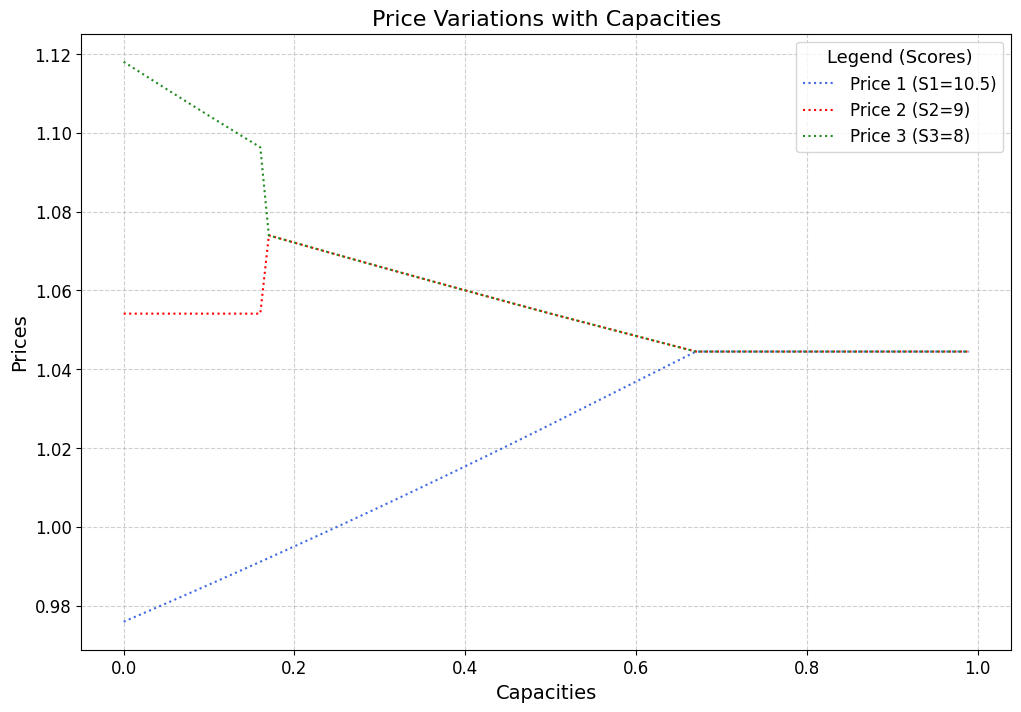

In [6]:
#other values for the function
#9,8,10 is fun


#set the variables
d_level1, d_el1, s_level1, s_el1 = 10, -2.0, 10.5, 0.0
d_level2, d_el2, s_level2, s_el2 = 10.0, -2.0, 9, 0.0
d_level3, d_el3, s_level3, s_el3 = 10, -2.0, 8, 0.0

#initialize lists to store capacities and prices where whichcase is 1
capacities = []
prices1 = []
prices2 = []
prices3 = []

#loop over capasities, they are all the same
for i in range(100):
    cap = i / 100
    whichcase, p1, p2, p3 = three_islands(d_level1, d_el1, s_level1, s_el1, d_level2, d_el2, s_level2, s_el2, d_level3, d_el3, s_level3, s_el3, cap, cap, cap)

    # Loop over each scenario index in whichcase
    for index in range(len(whichcase)):
        if whichcase[index] == 1:
            capacities.append(cap)
            prices1.append(p1[index])
            prices2.append(p2[index])
            prices3.append(p3[index])




# update default font sizes for better visibility
plt.rcParams.update({'font.size': 12})

# initiate a larger plot for enhanced readability
plt.figure(figsize=(12, 8))

# plot price data with dotted lines in distinct colors
plt.plot(capacities, prices1,  color='royalblue', markersize=5, linestyle='dotted', label='Price 1 (S1=10.5)')
plt.plot(capacities, prices2,  color='red', markersize=5, linestyle='dotted', label='Price 2 (S2=9)')
plt.plot(capacities, prices3, color='forestgreen', markersize=5, linestyle='dotted', label='Price 3 (S3=8)')

# add labels and title with specific font sizes
plt.xlabel('Capacities', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.title('Price Variations with Capacities', fontsize=16)

# implement a grid to facilitate data interpretation
plt.grid(True, linestyle='--', alpha=0.6)

# display the legend with adjusted font size and incorporate score values directly in the legend
plt.legend(title='Legend (Scores)', title_fontsize='13', fontsize=12)

# display the plot
plt.show()




